We solve :
$min_x\in R^n \quad \|x\|^2/2 + max \{\quad y^T x + y [n+1] \}$ subject to $Ay\leq b,$ and $-1\leq y\leq 1$

In [1]:
# using Pkg
using Gurobi
using JuMP
using Plots
using Random
using SpecialFunctions
using Ipopt
using Statistics
using HDF5, JLD

In [2]:
m = 40
n = 5*m

Random.seed!(42) 

A = 2 .*(rand(m, n+1) .- 0.5)
b = 2 .*(rand(m) .- 0.5)
c = 2 .*(rand(n) .-0.5)
x_init = 2 .*(rand(n) .- 0.5)
y_min = -1
y_max = 1

rho = 1
delta = 1e-3
epsilon = 2e-3
e = 1/2

0.5

In [3]:
function make_cut(x_value, i_model)
    @objective(i_model, Max, sum(i_model.obj_dict[:y][1:end-1] .* x_value) + i_model.obj_dict[:y][end]);
    optimize!(i_model)
    obj_value = objective_value(i_model)
    y_opt = value.(i_model.obj_dict[:y])
    return obj_value, y_opt
end

make_cut (generic function with 1 method)

In [4]:
function add_cut(x_value, m_model, dict_cut, i_model, iter)
    obj_value, y_opt = make_cut(x_value, i_model)
    dict_cut[iter] = @constraint(m_model, m_model.obj_dict[:z]>= sum(y_opt[1:end-1].*m_model.obj_dict[:x]) + y_opt[end]);
    return obj_value
end

add_cut (generic function with 1 method)

In [5]:
function make_inner_model(n,m,A,b)
    inner_model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(inner_model, "OutputFlag", 0)
    set_optimizer_attribute(inner_model, "FeasibilityTol", 1e-7)
    set_optimizer_attribute(inner_model, "OptimalityTol", 1e-7)
    # set_optimizer_attribute(inner_model, "Threads", 32)
    @variable(inner_model, y[1:n+1])

    @constraint(inner_model, y.<=1)
    @constraint(inner_model, y.>=-1)

    @constraint(inner_model, con[i=1:m], sum(A[i, j] * y[j] for j in 1:n+1) <= b[i]);
    return inner_model
end

make_inner_model (generic function with 1 method)

In [6]:
function make_master_model(n, rho, x_center)
    master_model =  Model(Ipopt.Optimizer)
#     set_optimizer_attribute(master_model, "OutputFlag", 0)
    set_optimizer_attribute(master_model, "print_level", 0)
    # set_optimizer_attribute(master_model, "Threads", 32)
    @variable(master_model, x[1:n])
    @variable(master_model, z)
    
    @NLobjective(master_model, Min,e*sum(x[i]^2 for i in 1:n) + z + rho*sum((x[i]-x_center[i])^2 for i in 1:n));
    
    return master_model
end

make_master_model (generic function with 1 method)

In [7]:
function update_proximal_center(m_model, x_c, rho)
    n = length(m_model.obj_dict[:x])
    @NLobjective(m_model, Min, e*sum(m_model.obj_dict[:x][i]^2 for i in 1:n) + m_model.obj_dict[:z] + rho*sum((m_model.obj_dict[:x][i]-x_c[i])^2 for i in 1:n));
end

update_proximal_center (generic function with 1 method)

In [8]:
function keep_active_cuts(dict_cut, m_model,n, verbose)
    dual_dict_cut = Dict(key => dual(value) for (key, value) in dict_cut)
    for k in (keys(dual_dict_cut))
        if (dual_dict_cut[k])<1e-5
            if verbose
                println("Cut ",k," deleted")
            end
            delete(m_model, dict_cut[k])
            pop!(dict_cut, k)
            pop!(dual_dict_cut, k)
        end
    end
    if length(dual_dict_cut)>n+1
        to_discard = keys(sort(collect(dual_dict_cut), by = x -> x[2])[1:length(dual_dict_cut)-n-1])
        for k in to_discard
            if verbose
                println("Cut ",k," deleted")
            end
            delete(m_model, dict_cut[k])
            pop!(dict_cut, k)
        end
    end
end

keep_active_cuts (generic function with 1 method)

In [9]:
function keep_all_cuts(dict_cut, master_model, verbose)
end

function clear_all_cut_but(dict_cut, master_model, lst_to_keep, verbose)
    for k in keys(dict_cut)
        if !(k in lst_to_keep)
            if verbose
                println("Cut ",k," deleted")
            end
            delete(master_model, dict_cut[k])
            pop!(dict_cut, k)
        end
    end
end

clear_all_cut_but (generic function with 1 method)

In [10]:
# manage_bundle = KEEP_ALL
@enum Manage_bundle Keep_all Keep_active Keep_active_null_step
color_dic = Dict(Keep_all=>"green", Keep_active=>"red", Keep_active_null_step=>"blue");
dic_names_method = Dict(Keep_all=>"All-cut", Keep_active=>"Active-cut", Keep_active_null_step=>"Single-cut");

In [11]:
function solve(x_init, n,m,A,b,rho,epsilon,delta, manage_bundle, goal_obj, verbose = false)
    x_value = x_init
    inner_model = make_inner_model(n,m,A,b)
    master_model = make_master_model(n, rho, x_init)
    dict_cut = Dict()
    master_obj_value = Inf
    last_master_obj_value = Inf
    f_k_value = Inf
    g_value = Inf
    f_value = -Inf 
    list_number_null_steps = [1]
    number_serious_steps = 0
    bundle_size = [0]
    t = time()
    list_obj_value_gap = []
    max_iter = 100000
    for iter in 1:max_iter
        last_f_value = f_value
        f_value = add_cut(x_value, master_model, dict_cut, inner_model, iter)
        
        if iter >= 2
            master_obj_value = g_value + f_value
            push!(list_obj_value_gap, master_obj_value)
            if verbose
                println("Objective value master problem ", master_obj_value)
            end
            primal_gap = f_value - f_k_value
            if verbose
                println("----------- ITERATION ", iter, " ---------")
                println("The primal_gap is: ", primal_gap)
            end
            if primal_gap<delta
            # if (last_f_value - f_value)>0.5*(last_f_value - f_k_value)
                if goal_obj<-1e9
                    if primal_gap<delta
                       break 
                    end
                end
                number_serious_steps+=1
                if master_obj_value - goal_obj < epsilon
                    println("Number of iterations : ", iter)
                    break
                else
                    last_master_obj_value = master_obj_value
                end
                push!(list_number_null_steps, 0)
                update_proximal_center(master_model, x_value, rho)
                if manage_bundle == Keep_active_null_step
                    clear_all_cut_but(dict_cut, master_model, [iter], verbose)
                end
                if verbose
                    println("*****NEW PROX CENTER*****")
                end
            else
                list_number_null_steps[number_serious_steps+1]+=1
            end
        end
        optimize!(master_model)
#         g_value = log(exp(value(sum(master_model.obj_dict[:x][i]^2 for i in 1:n)))+1)
        g_value =  e*value(sum(master_model.obj_dict[:x][i]^2 for i in 1:n))
        # g_value =  value(sum(master_model.obj_dict[:x][i]*c[i] for i in 1:n))
        
        x_value = value.(master_model.obj_dict[:x])
        f_k_value = value(master_model.obj_dict[:z])
        if manage_bundle == Keep_all
            keep_all_cuts(dict_cut, master_model,verbose)
        else
            keep_active_cuts(dict_cut, master_model, n, verbose)
        end
        push!(bundle_size, length(dict_cut))
#         println(g_value, "  ", f_value)
        if iter== max_iter
            println("optimization_failed")
            runtime = 3600
        end
    end
    runtime = time()-t
    
    return dict_cut,master_model, list_number_null_steps, number_serious_steps, bundle_size,runtime, list_obj_value_gap
end

solve (generic function with 2 methods)

In [12]:
function find_optimal_value(A,b,n,m,e)
    dual_model =  Model(Ipopt.Optimizer)
    #     set_optimizer_attribute(master_model, "OutputFlag", 0)
    set_optimizer_attribute(dual_model, "print_level", 0)
    # set_optimizer_attribute(master_model, "Threads", 32)
    @variable(dual_model, x[1:n])
    @variable(dual_model, lambda[1:m]<=0)
    @variable(dual_model, mu_g_plus[1:n+1]<=0)
    @variable(dual_model, mu_g_moins[1:n+1]>=0)
    @variable(dual_model, z[1:n+1])

    @constraint(dual_model, con[i=1:n], x[i] == z[i])
    @constraint(dual_model, z[n+1]==1)

    @constraint(dual_model, A' * lambda + mu_g_plus + mu_g_moins + z == 0)


    #     @NLobjective(master_model, Min,log(exp(sum(x[i]^2 for i in 1:n))+1) + z + rho*sum((x[i]-x_center[i])^2 for i in 1:n));
    @NLobjective(dual_model, Min,e*sum(x[i]^2 for i in 1:n) - sum(lambda[j]*b[j] for j in 1:m) - sum(mu_g_plus[i] - mu_g_moins[i] for i in 1:n+1) )
    optimize!(dual_model)
    return objective_value(dual_model)
end
# @NLobjective(master_model, Min,sum(x[i]*c[i] for i in 1:n) + z + rho*sum((x[i]-x_center[i])^2 for i in 1:n));


In [13]:
goal_obj = find_optimal_value(A,b,n,m,e)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



0.8934453798317016

# Bundle size

In [14]:
# plot(dic_gaps)
manage_bundle_values = [Keep_active_null_step, Keep_active, Keep_all]

3-element Vector{Manage_bundle}:
 Keep_active_null_step::Manage_bundle = 2
 Keep_active::Manage_bundle = 1
 Keep_all::Manage_bundle = 0

In [15]:
manage_bundle_values = [Keep_active_null_step, Keep_active, Keep_all]
dic_gaps = Dict()
dic_bundle_size = Dict()
# Plot the bundle sizes for each value of manage_bundle
for manage_bundle in manage_bundle_values
    dict_cut, master_model, list_number_null_steps, number_serious_steps, bundle_size, runtime, list_obj_value_gap = solve(x_init, n, m, A, b, rho, epsilon, delta, manage_bundle, goal_obj, false)
    println(manage_bundle, " -- Runtime : ", runtime) 
    dic_bundle_size[manage_bundle] = bundle_size
    dic_gaps[manage_bundle] = list_obj_value_gap .- goal_obj
end

Set parameter TokenServer to value "flexlm"
Set parameter FeasibilityTol to value 1e-07
Set parameter OptimalityTol to value 1e-07
Number of iterations : 1064
Keep_active_null_step -- Runtime : 41.908470153808594
Set parameter TokenServer to value "flexlm"
Set parameter FeasibilityTol to value 1e-07
Set parameter OptimalityTol to value 1e-07
Number of iterations : 541
Keep_active -- Runtime : 23.85603404045105
Set parameter TokenServer to value "flexlm"
Set parameter FeasibilityTol to value 1e-07
Set parameter OptimalityTol to value 1e-07
Number of iterations : 449
Keep_all -- Runtime : 67.5908420085907


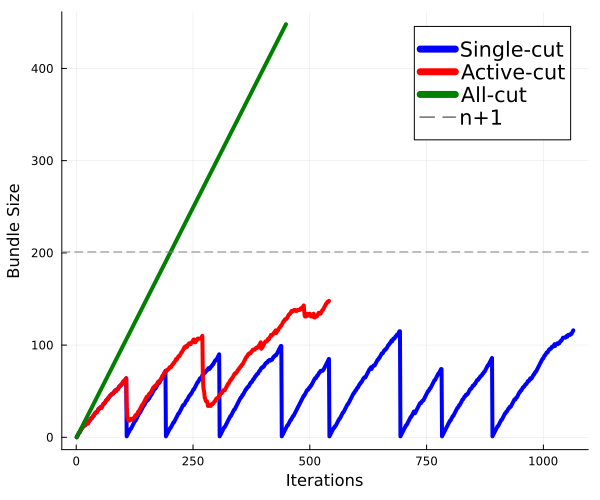

In [16]:
p = plot(size = (600,500))
for manage_bundle in manage_bundle_values
    plot!(dic_bundle_size[manage_bundle], label=dic_names_method[manage_bundle], color = color_dic[manage_bundle],linewidth=4)
end
hline!([n+1], linestyle=:dash, label="n+1", color = "grey")
xlabel!("Iterations")
ylabel!("Bundle Size")
plot!(legendfontsize=14)
# title!("Bundle Size for Different Bundle management strategies")
savefig(p, "Bundle_size.pdf")  
plot!()

# Objective value gap

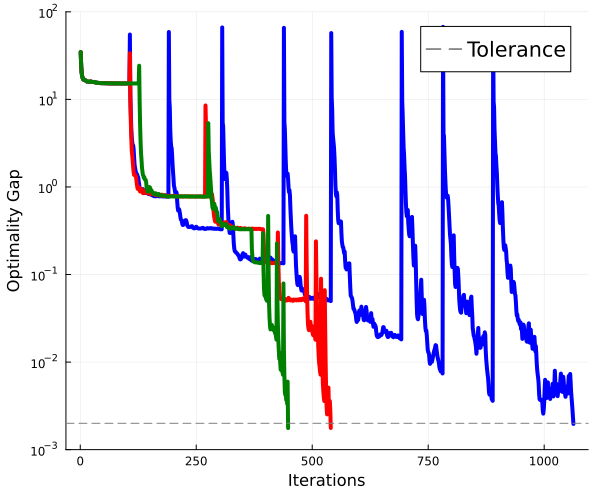

In [17]:
p = plot(size = (600,500))
for manage_bundle in manage_bundle_values
    plot!(dic_gaps[manage_bundle], label = "", color = color_dic[manage_bundle],linewidth=4)
end
hline!([epsilon], linestyle=:dash, label="Tolerance", color = "grey")
xlabel!("Iterations")
ylabel!("Optimality Gap")
plot!(legendfontsize=14)
# y_ticks = range(1e-4, stop=1e1, length=20)
# title!("Progress for different bundle management strategies")
plot!(yaxis=:log, yticks = [1e-5, 1e-4, 1e-3, 1e-2,1e-1, 1, 10, 100])
ylims!(1e-3, 100)
savefig(p, "Optimality_gap.pdf") 
plot!()

# Runtime

In [23]:
manage_bundle_values = [Keep_active_null_step, Keep_active, Keep_all]
seeds = [123, 456, 789, 101, 112, 131, 415, 161, 718, 192, 202, 303, 404, 505, 606, 707, 808, 909, 1010, 1111]
# Define initial values
step_size = 5
# m_values = 10:step_size:55
m_values = 10:step_size:15
ratio = 5

5

In [24]:
runtime_values_by_seed = Dict(s=>Dict() for s in seeds)

# Loop over different m values
for m in m_values
    save("runtime_values_by_seed.jld", "runtime_values_by_seed", runtime_values_by_seed)
    for seed in seeds
        n = ratio*m
        # Initialize A, b, x_init, and x_center
        Random.seed!(seed)
        A = rand(m, n+1) .- 0.5
        b = rand(m) .- 0.5
        x_init = rand(n) .- 0.5
        #FIND THE VALUE OF THE PROBLEM
        goal_obj = find_optimal_value(A,b,n,m,e)
        for manage_bundle in manage_bundle_values
            println(m,"   ", manage_bundle)
            # Call the solve function directly and retrieve runtime
            _, _, _, _, _, runtime, list_obj_value_gap = solve(x_init, n, m, A, b, rho, epsilon, delta, manage_bundle, goal_obj, false)
            println("runtime : ", runtime, " --- obj_value = ", list_obj_value_gap[end])
            # Store runtime for the current manage_bundle
            if haskey(runtime_values_by_seed[seed], manage_bundle)
                push!(runtime_values_by_seed[seed][manage_bundle], runtime)
            else
                runtime_values_by_seed[seed][manage_bundle] = [runtime]
            end
        end
    end
end

10   Keep_active_null_step
Set parameter TokenServer to value "flexlm"
Set parameter FeasibilityTol to value 1e-07
Set parameter OptimalityTol to value 1e-07
Number of iterations : 200
runtime : 1.6621580123901367 --- obj_value = 0.8961793027250744
10   Keep_active
Set parameter TokenServer to value "flexlm"
Set parameter FeasibilityTol to value 1e-07
Set parameter OptimalityTol to value 1e-07
Number of iterations : 75
runtime : 0.6856050491333008 --- obj_value = 0.8958825332417057
10   Keep_all
Set parameter TokenServer to value "flexlm"
Set parameter FeasibilityTol to value 1e-07
Set parameter OptimalityTol to value 1e-07
Number of iterations : 67
runtime : 0.8961880207061768 --- obj_value = 0.8953510800768354
10   Keep_active_null_step
Set parameter TokenServer to value "flexlm"
Set parameter FeasibilityTol to value 1e-07
Set parameter OptimalityTol to value 1e-07
Number of iterations : 183
runtime : 1.4189250469207764 --- obj_value = 0.9067277870651855
10   Keep_active
Set paramete

In [25]:
bundle_m = keys(runtime_values_by_seed[seeds[1]])
number_sizes = length(m_values)
number_sizes = length(runtime_values_by_seed[456][Keep_all])
avg_runtimes = Dict()
std_runtimes = Dict()
q_25_runtimes = Dict()
q_75_runtimes = Dict()
q_10_runtimes = Dict()
q_90_runtimes = Dict()
for method in bundle_m
    avg_runtimes[method] = []
    std_runtimes[method] = []
    q_25_runtimes[method] = []
    q_75_runtimes[method] = []
    q_10_runtimes[method] = []
    q_90_runtimes[method] = []
    
    for i in 1:number_sizes
        l = []
        for seed in seeds
            push!(l, runtime_values_by_seed[seed][method][i])
        end
        push!(avg_runtimes[method], mean(l))
        push!(std_runtimes[method], std(l))
        push!(q_25_runtimes[method], quantile(l, 0.25))
        push!(q_75_runtimes[method], quantile(l, 0.75))
        push!(q_10_runtimes[method], quantile(l, 0.10))
        push!(q_90_runtimes[method], quantile(l, 0.90))
    end
end

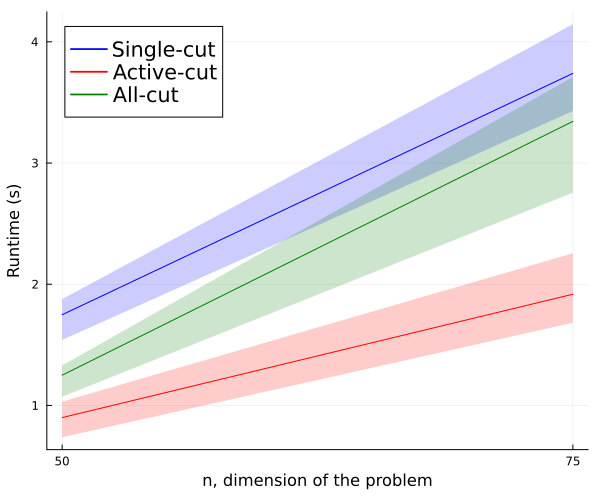

In [26]:
p = plot(size=(600, 500))
for manage_bundle in manage_bundle_values
    runtime = avg_runtimes[manage_bundle]
    stds = std_runtimes[manage_bundle]
    q25 = q_25_runtimes[manage_bundle]
    q75 = q_75_runtimes[manage_bundle]
    q10 = q_10_runtimes[manage_bundle]
    q90 = q_90_runtimes[manage_bundle]
   # plot!(m_values .* ratio, yerr=stds./sqrt(length(seeds)), runtime, label = dic_names_method[manage_bundle], color = color_dic[manage_bundle], linewidth = 4)
    # q_25_runtimes
    # plot!(m_values .* ratio, q25, fillrange = q75, fillalpha = 0.35, c = 1, label = dic_names_method[manage_bundle], color = color_dic[manage_bundle])
    plot!(m_values .* ratio, runtime, ribbon=(runtime .- q25, q75 .- runtime), label=dic_names_method[manage_bundle], fillalpha=0.2, color = color_dic[manage_bundle])
end
xlabel!("n, dimension of the problem")
ylabel!("Runtime (s)")
plot!(legendfontsize=14, xticks = m_values .* ratio)
# title!("Runtime for different bundle management strategies")
savefig(p, "Runtimes.pdf") 
plot!()

In [27]:
# save("runtime_values_by_seed.jld", "runtime_values_by_seed", runtime_values_by_seed)
# runtime_values_by_seed = load("runtime_values_by_seed.jld")["runtime_values_by_seed"]